# Scheduling time modeling

Goal is to model the Scheduling time given a configuration so it can be applied in online inference

## Dataset Variables Description for vLLM Inference Benchmark

- `gpu_loras`: Integer - Number of LoRA adapters cached in GPU.
- `cpu_loras`: Integer - Total number of LoRA adapters deployed on the system (stored in CPU memory). Always greater than or equal to `gpu_loras`.
- `cpu_gpu_diff`: Integer - Difference between `cpu_loras` and `gpu_loras`. Represents additional LoRAs that must be loaded from CPU when needed.
- `rank`: Integer - The rank of LoRA adapters used in the experiment. Represents the parameter size/complexity of the adapters. 
    - **Ignored by this analysis as we have it fixed. Still, not important for us as the main change is the model size, and scheduling is agnostic of the model.**
- `rate`: Float - Aggregated arrival rate of inference requests to the system. Values in the dataset: [1, 5, 10, 50, 100, 150].
- `output_throughput`: Float - Number of output tokens generated per second by the system during the benchmark.
    - **Shouldn't be considered as we are modeling for an online system**
    - **Not sure if considered or not, it is correlated to batch size.**
- `completed_requests`: Integer - Total number of inference requests successfully processed during the experiment. 
    - **Shouldn't be considered as we are modeling for an online system**
- `adapter_rates`: Float - Per-adapter request rate. Calculated as `rate` divided by `cpu_loras` (uniformly distributed).
- `max_lora_loading_time`: Float - Total time (in seconds) taken for the swapping of LoRA adapters from CPU to GPU during the experiment.
    - Correlated to the `max_lora_loads_from_memory_corrected`.
    - **Shouldn't be considered as we are modeling for an online system**
- `avg_batch_size`: Float - Average number of requests batched together for processing.
- `avg_waiting_queue`: Float - Average number of requests waiting in the queue during the experiment. 
- `max_lora_loads_from_memory`: Float - Total number of LoRA loads from CPU memory into GPU.    
    - **Shouldn't be considered as we are modeling for an online system**
- `max_lora_loads_from_disk`: Float - Total number of LoRA loads from disk to CPU memory.
    - Correlated to `cpu_loras`.
    - **Shouldn't be considered as we are modeling for an online system**
- `max_lora_loads_from_memory_corrected`: Float - Adjusted total count of LoRA loads from memory.
    - Difference with `max_lora_loads_from_memory` is that the previous first loads as many CPU LoRAs as defined, to have them ready for online serving. This ressets the count to 0. 
    - **Shouldn't be considered as we are modeling for an online system**
- `total_scheduling_time`: Float - Total time (in seconds) spent scheduling requests for the experiment.
    - **Cannot be used as a target variable yet. Needs to be normalized by request, that would be our target `scheduling_time_per_step`.**
- `processed_tokens`: Integer - Total number of tokens processed during the experiment.
    - **Shouldn't be considered as we are modeling for an online system**
- `duration`: Float - Total duration of the experiment in seconds.
    - **Shouldn't be considered as we are modeling for an online system**
- `mean_loras_by_batch`: Float - Average number of unique LoRAs used per batch during the experiment.
- `steps`: Int - Total number of steps performed in that experiment. Used to calculate the scheduling_time_per_step.
    - **Shouldn't be considered as we are modeling for an online system**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
import warnings
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("viridis")

# Load your data
csv_file = './metrics_data_aggregated_rate.csv'  # Update with your file path
df = pd.read_csv(csv_file)

# Calculate scheduling time per request
df['scheduling_time_per_step'] = (df['total_scheduling_time'] / df['steps']) # we convert to milliseconds
# We filter out rows where cpu_gpu_diff is 0, as they wouldn't have any scheduling time.
# df = df[df['cpu_gpu_diff'] != 0]
# Still, might be interesting to keep them just to make the modeling more robust to those cases, which exist.

# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()
df.isnull().sum()


Dataset shape: (336, 21)

Column names:
['gpu_loras', 'cpu_loras', 'cpu_gpu_diff', 'rank', 'rate', 'output_throughput', 'completed_requests', 'adapter_rates', 'max_lora_loading_time', 'avg_batch_size', 'avg_waiting_queue', 'max_lora_loads_from_memory', 'max_lora_loads_from_disk', 'max_lora_loads_from_memory_corrected', 'total_scheduling_time', 'mean_itl_ms', 'processed_tokens', 'duration', 'mean_loras_by_batch', 'steps', 'scheduling_time_per_step']

First few rows:


gpu_loras                               0
cpu_loras                               0
cpu_gpu_diff                            0
rank                                    0
rate                                    0
output_throughput                       0
completed_requests                      0
adapter_rates                           0
max_lora_loading_time                   0
avg_batch_size                          0
avg_waiting_queue                       0
max_lora_loads_from_memory              0
max_lora_loads_from_disk                0
max_lora_loads_from_memory_corrected    0
total_scheduling_time                   0
mean_itl_ms                             0
processed_tokens                        0
duration                                0
mean_loras_by_batch                     0
steps                                   0
scheduling_time_per_step                0
dtype: int64

In [2]:
csv_file = './metrics_data_adapter_rates.csv' 
adapter_rate_df = pd.read_csv(csv_file)

# Calculate scheduling time per request
adapter_rate_df['scheduling_time_per_step'] = adapter_rate_df['total_scheduling_time'] / adapter_rate_df['steps']
adapter_rate_df.columns

Index(['gpu_loras', 'cpu_loras', 'cpu_gpu_diff', 'rank', 'rate',
       'output_throughput', 'completed_requests', 'adapter_rates',
       'max_lora_loading_time', 'avg_batch_size', 'avg_waiting_queue',
       'max_lora_loads_from_memory', 'max_lora_loads_from_disk',
       'max_lora_loads_from_memory_corrected', 'total_scheduling_time',
       'mean_itl_ms', 'processed_tokens', 'duration', 'mean_loras_by_batch',
       'steps', 'scheduling_time_per_step'],
      dtype='object')

We concatenate both datasets to train the models on larger data.

In [3]:
combined = pd.concat([df, adapter_rate_df], ignore_index=True)


In [4]:
combined

,gpu_loras,cpu_loras,cpu_gpu_diff,rank,rate,output_throughput,completed_requests,adapter_rates,max_lora_loading_time,avg_batch_size,...,max_lora_loads_from_memory,max_lora_loads_from_disk,max_lora_loads_from_memory_corrected,total_scheduling_time,mean_itl_ms,processed_tokens,duration,mean_loras_by_batch,steps,scheduling_time_per_step
0,8,8,0,8,1.0,226.379365,588,0.125000,0.067586,5.874552,...,8.0,8.0,0.0,0.993855,25.847656,135828,600.001684,4.065602,23301,0.000043
1,8,16,8,8,1.0,225.609058,586,0.062500,2.273233,6.093190,...,331.0,16.0,315.0,0.949654,26.471115,135366,600.002504,4.764841,22833,0.000042
2,8,32,24,8,1.0,225.994110,587,0.031250,3.786232,6.061151,...,559.0,32.0,527.0,0.968009,26.226961,135597,600.002363,5.200201,23105,0.000042
3,8,64,56,8,1.0,227.919238,592,0.015625,5.089392,6.043011,...,733.0,64.0,669.0,0.987342,26.828487,136752,600.002005,5.618815,22667,0.000044
4,8,128,120,8,1.0,227.533774,591,0.007812,6.284206,6.197133,...,869.0,128.0,741.0,0.992056,27.320559,136521,600.003233,5.775044,22378,0.000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,384,384,0,8,0.2,1306.112453,3401,0.200000,3.095413,151.240741,...,384.0,384.0,0.0,3.607795,147.486504,785631,601.503338,102.224408,5443,0.000663
784,384,448,64,8,0.2,1221.580160,3181,0.200000,7.811515,149.316176,...,946.0,448.0,498.0,3.430728,151.332366,734811,601.524995,102.643728,5251,0.000653
785,384,512,128,8,0.2,1156.217005,3011,0.200000,10.827059,147.635593,...,1333.0,512.0,821.0,3.833155,155.896338,695541,601.566139,103.240859,5125,0.000748
786,448,448,0,8,0.2,1064.252307,2772,0.200000,3.834463,129.370370,...,448.0,448.0,0.0,3.107211,149.764564,640332,601.673114,92.362925,5310,0.000585


We get rid of rank, completed_requests, max_lora_loads_from_memory, total_scheduling_time, processed_tokens, duration, max_lora_loads_from_disk.

In [5]:
# df.columns #previous code, if we dont want to use the combined dataframe, use that.
df = combined.copy()

In [6]:
df=df[['gpu_loras', 'cpu_loras', 'cpu_gpu_diff', 
       'rate', 'adapter_rates', 'avg_batch_size', 'avg_waiting_queue', 
       'mean_loras_by_batch','scheduling_time_per_step']]

#### Descriptive analysis

In [7]:
df.dtypes

gpu_loras                     int64
cpu_loras                     int64
cpu_gpu_diff                  int64
rate                        float64
adapter_rates               float64
avg_batch_size              float64
avg_waiting_queue           float64
mean_loras_by_batch         float64
scheduling_time_per_step    float64
dtype: object

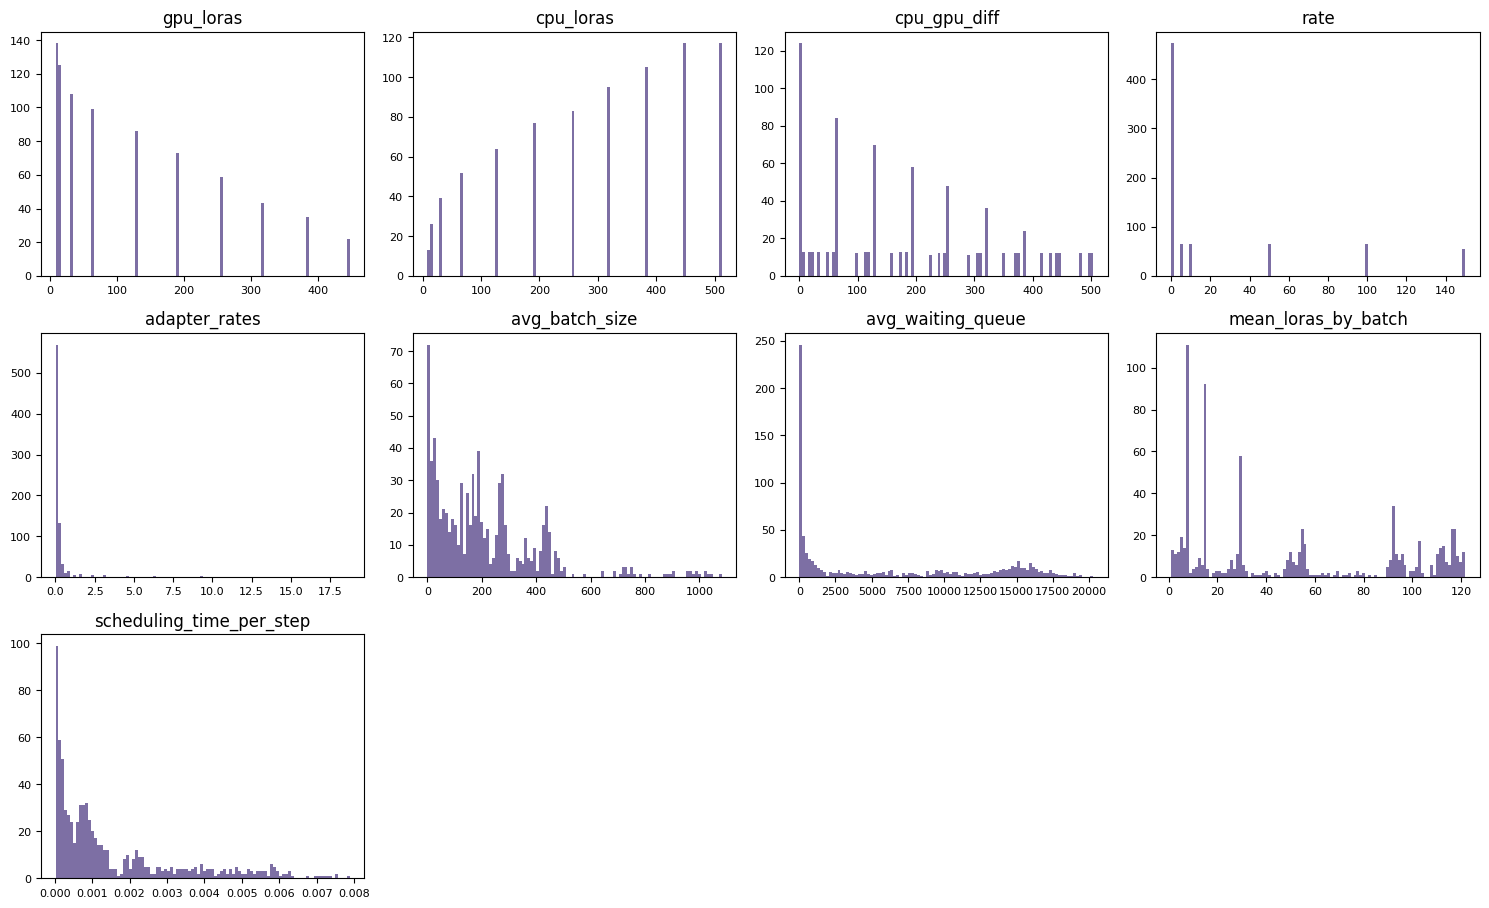

In [8]:
# Simple histogram plots for each feature
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    if i < len(axes):
        axes[i].hist(df[col], bins=100, alpha=0.7)
        axes[i].set_title(col)
        axes[i].tick_params(axis='both', which='major', labelsize=8)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

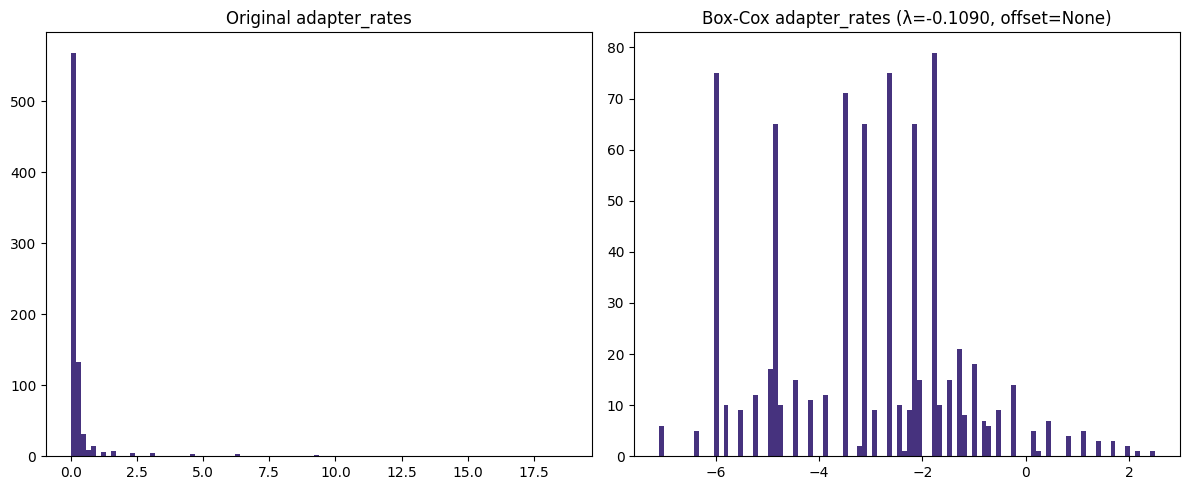

Transformed adapter_rates with λ=-0.1090, offset=None


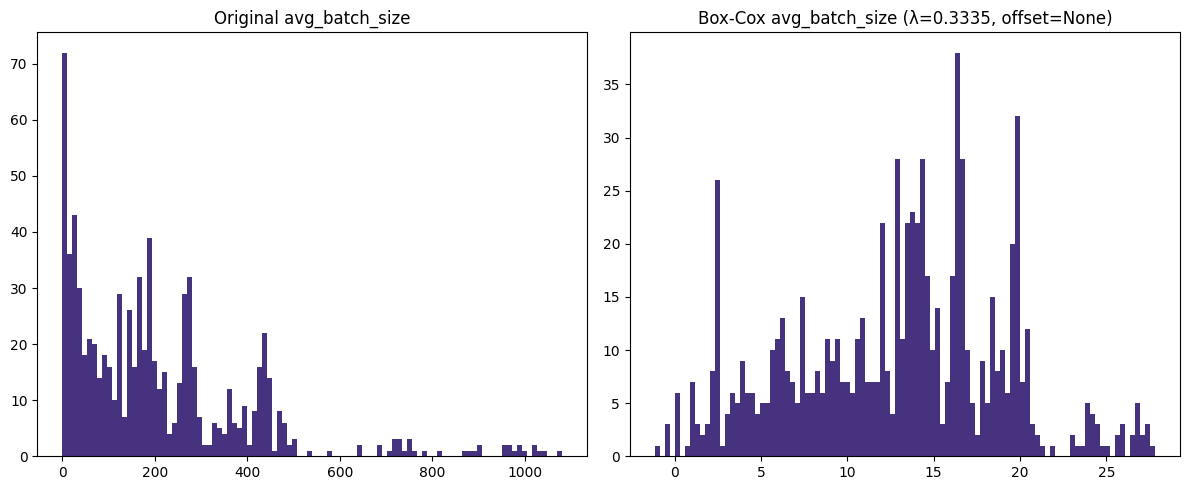

Transformed avg_batch_size with λ=0.3335, offset=None


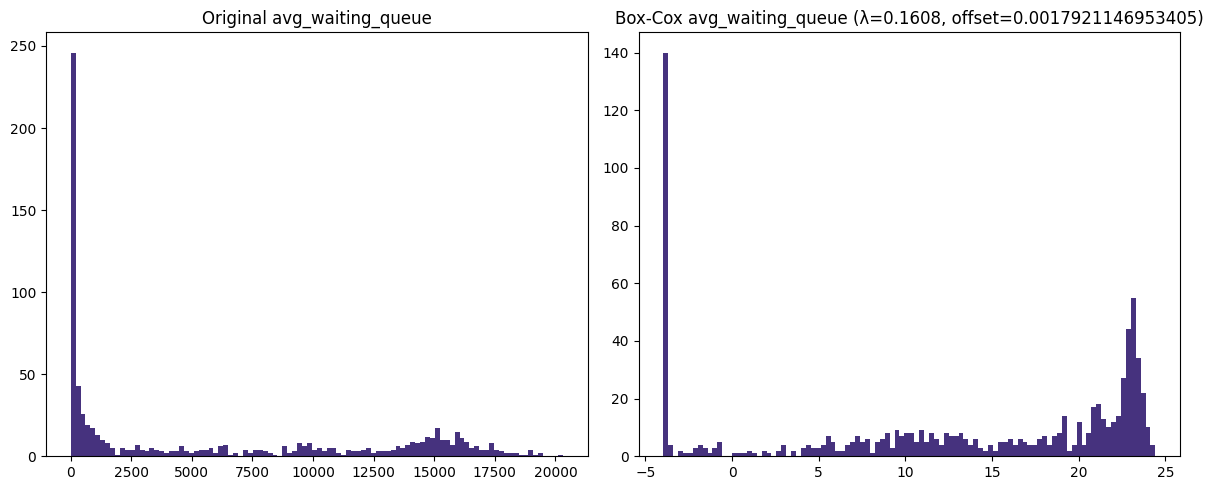

Transformed avg_waiting_queue with λ=0.1608, offset=0.0017921146953405


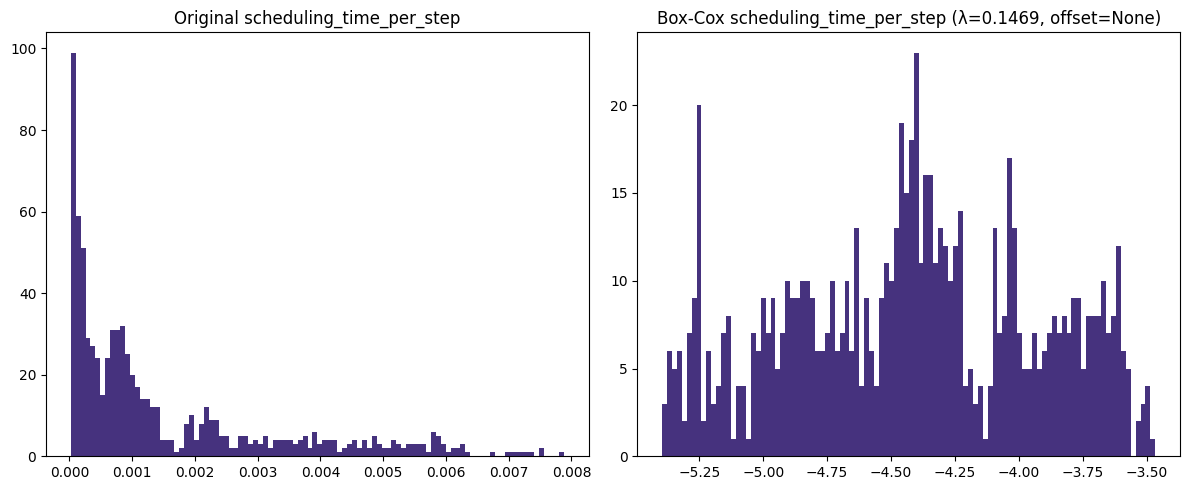

Transformed scheduling_time_per_step with λ=0.1469, offset=None


In [9]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to apply Box-Cox with handling of zeros/negatives
def boxcox_transform(x, offset=None):
    # Find minimum value
    x_min = x.min()
    
    # If there are zeros or negative values, add an offset
    if x_min <= 0:
        if offset is None:
            # Calculate a suitable offset: either 1 or a small fraction of positive values
            if len(x[x > 0]) > 0:
                # Use half the minimum non-zero value
                offset = x[x > 0].min() / 2
            else:
                offset = 1.0
        
        # Apply offset
        x_shifted = x + offset
    else:
        x_shifted = x
    
    # Apply Box-Cox transform
    transformed, lambda_value = stats.boxcox(x_shifted)
    
    return transformed, lambda_value, offset

# Example application to columns with zeros
columns_to_transform = ['adapter_rates', 'avg_batch_size','avg_waiting_queue','scheduling_time_per_step'] 
df_transformed = df.copy()

for col in columns_to_transform:
    # Skip if all values are the same (Box-Cox will fail)
    if df[col].nunique() <= 1:
        print(f"Skipping {col} - not enough unique values for Box-Cox")
        continue
        
    try:
        transformed_values, lambda_val, offset = boxcox_transform(df[col])
        df_transformed[f'boxcox_{col}'] = transformed_values
        
        # Visualize before and after
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.hist(df[col], bins=100)
        plt.title(f'Original {col}')
        
        plt.subplot(1, 2, 2)
        plt.hist(df_transformed[f'boxcox_{col}'], bins=100)
        plt.title(f'Box-Cox {col} (λ={lambda_val:.4f}, offset={offset})')
        plt.tight_layout()
        plt.show()
        
        print(f"Transformed {col} with λ={lambda_val:.4f}, offset={offset}")
    except Exception as e:
        print(f"Error transforming {col}: {e}")

After applying Box Cox:
* 'adapter_rates': lambda=-0.06 log(x).
* 'avg_batch_size': lambda=0.27 sqrt(x).
* 'avg_waiting_queue',: no transformation required, not improving.
* 'max_lora_loads_from_memory_corrected': lambda=0.16 log(x)
* 'scheduling_time_per_step': lambda=0.159  log(x)

In [10]:
import numpy as np

# Create a copy of the dataframe for transformations
df_transformed = df.copy()
epsilon = 1e-10

# Log transformations (lambda ≈ 0)
df_transformed['adapter_rates_log'] = np.log(df['adapter_rates'] + epsilon)
# df_transformed['max_lora_loading_time_log'] = np.log(df['max_lora_loading_time'] + epsilon)
# df_transformed['max_lora_loads_from_memory_corrected_log'] = np.log(df['max_lora_loads_from_memory_corrected'] + epsilon)
# Square root transformation (lambda ≈ 0.27)
df_transformed['avg_batch_size_sqrt'] = np.sqrt(df['avg_batch_size'])
# For inverse transformation (λ≈-1): y = 1 - 1/x
# df_transformed['scheduling_time_per_step_log '] = np.log(df['scheduling_time_per_step'] + epsilon)



In [11]:
# Get all column names excluding the target variables
feature_cols = [col for col in df_transformed.columns if 'step' not in col]

# Sort feature columns alphabetically
feature_cols.sort()

# Add target variables at the end
sorted_cols = feature_cols + ['scheduling_time_per_step']

# Reorder the dataframe columns
df_transformed = df_transformed[sorted_cols]

# Show the new column order
print(df_transformed.columns.tolist())

['adapter_rates', 'adapter_rates_log', 'avg_batch_size', 'avg_batch_size_sqrt', 'avg_waiting_queue', 'cpu_gpu_diff', 'cpu_loras', 'gpu_loras', 'mean_loras_by_batch', 'rate', 'scheduling_time_per_step']


In [12]:
len(df_transformed.columns)

11

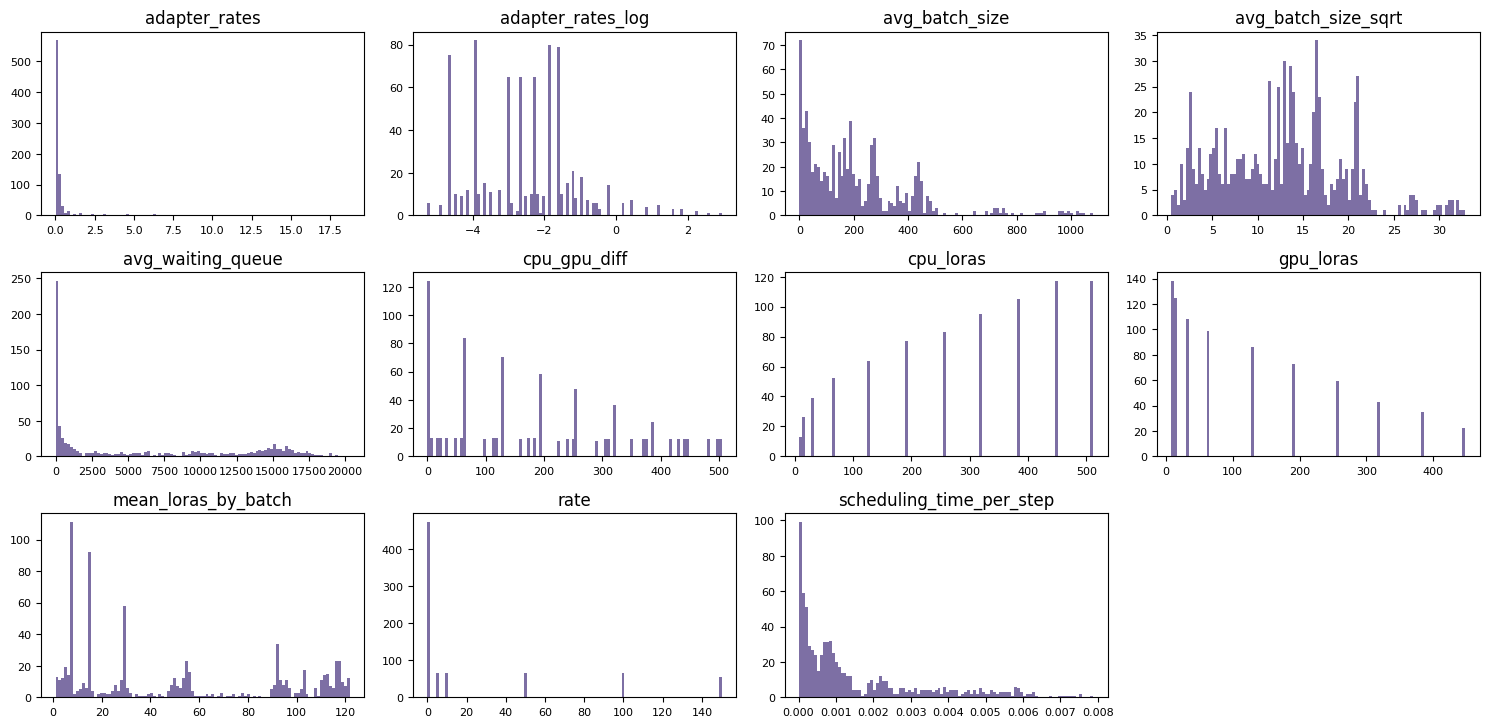

In [13]:
# Simple histogram plots for each feature
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 4, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df_transformed.columns):
    if i < len(axes):
        axes[i].hist(df_transformed[col], bins=100, alpha=0.7)
        axes[i].set_title(col)
        axes[i].tick_params(axis='both', which='major', labelsize=8)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

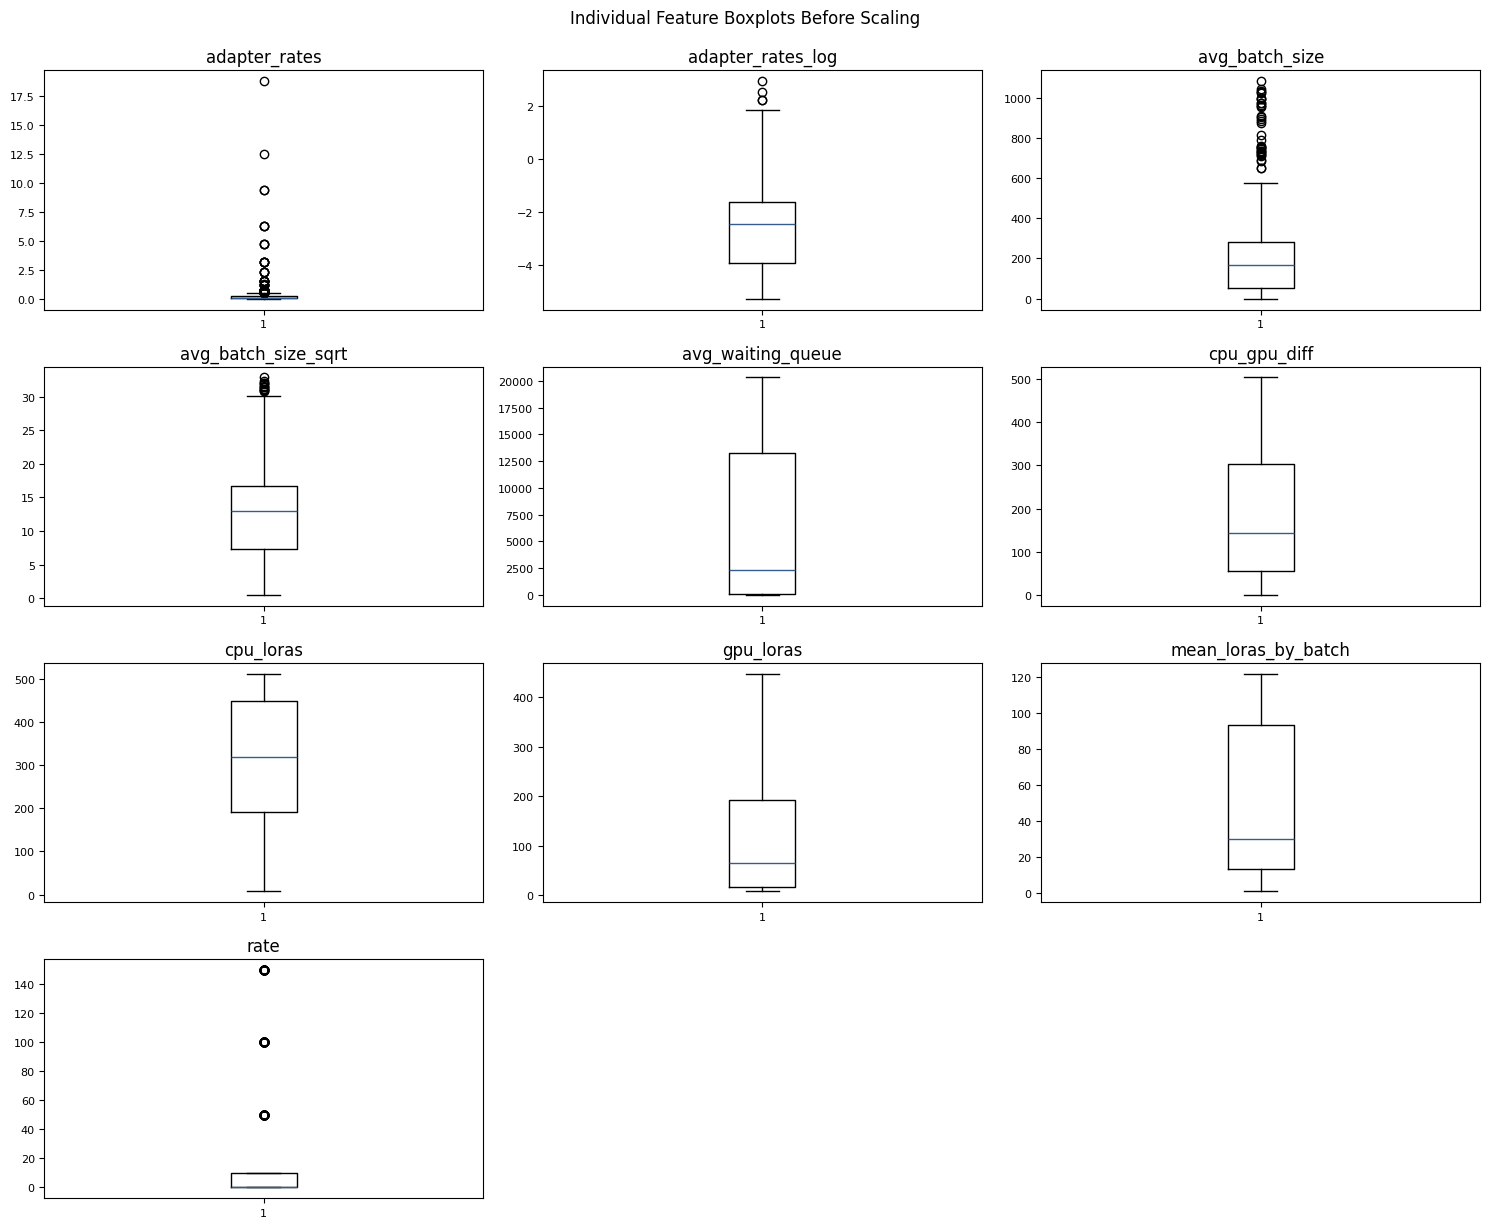

In [14]:
# 1. Plot individual boxplots for each feature (better for different scales)
numeric_cols = df_transformed.select_dtypes(include=['float64', 'int64']).columns
target_cols = ['scheduling_time_per_step', 'scheduling_time_per_step_log']
cols_to_process = [col for col in numeric_cols if col not in target_cols]

# Calculate number of rows and columns for subplots
n_features = len(cols_to_process)
n_cols = 3 # Number of columns in subplot grid
n_rows = (n_features + n_cols - 1) // n_cols # Ceiling division for rows needed

# Create individual boxplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten() # Flatten to make indexing easier

for i, col in enumerate(cols_to_process):
    if i < len(axes): # Safety check
        axes[i].boxplot(df_transformed[col])
        axes[i].set_title(col)
        axes[i].tick_params(axis='both', which='major', labelsize=8)

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Individual Feature Boxplots Before Scaling', y=1.02)
plt.show()

# 2. Remove outliers with 3 IQR (less aggressive than 1.5 IQR)
def remove_outliers(df, columns):
    df_clean = df.copy()
    outlier_counts = {}
    mask = np.ones(len(df), dtype=bool)
    all_outliers = []
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 5 * IQR
        upper_bound = Q3 + 5 * IQR
        
        col_mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
        outlier_counts[col] = (~col_mask).sum()
        
        # Collect outliers for this column
        col_outliers = df[~col_mask]
        if len(col_outliers) > 0:
            all_outliers.append({
                'column': col,
                'outliers': col_outliers,
                'bounds': (lower_bound, upper_bound)
            })
        
        mask = mask & col_mask
    
    df_clean = df_clean[mask]
    outlier_rows = df[~mask]
    
    print(f"Removed {len(df) - len(df_clean)} rows with outliers")
    print("Outlier counts by column:")
    for col, count in outlier_counts.items():
        if count > 0:
            print(f" {col}: {count} outliers")
    
    # Print the outliers for inspection
    if len(outlier_rows) > 0:
        print(outlier_rows)
        
        print("\nOutlier details by column:")
        for outlier_info in all_outliers:
            col = outlier_info['column']
            outliers = outlier_info['outliers']
            bounds = outlier_info['bounds']
            if len(outliers) > 0:
                print(f"\n{col} outliers (bounds: {bounds[0]:.3f} to {bounds[1]:.3f}):")
                print(outliers[[col]].head(5))
    
    return df_clean

# Apply outlier removal
# df_no_outliers = remove_outliers(df_transformed, cols_to_process)
df_no_outliers=df_transformed

# print(f"Original shape: {df_transformed.shape}")
# print(f"Final shape after outlier removal and scaling: {df_no_outliers.shape}, Percentage of outliers:{100*(1-(df_no_outliers.shape[0]/df_transformed.shape[0]))}%")


In [15]:
df_no_outliers

,adapter_rates,adapter_rates_log,avg_batch_size,avg_batch_size_sqrt,avg_waiting_queue,cpu_gpu_diff,cpu_loras,gpu_loras,mean_loras_by_batch,rate,scheduling_time_per_step
0,0.125000,-2.079442,5.874552,2.423748,0.000000,0,8,8,4.065602,1.0,0.000043
1,0.062500,-2.772589,6.093190,2.468439,0.089606,8,16,8,4.764841,1.0,0.000042
2,0.031250,-3.465736,6.061151,2.461941,0.187050,24,32,8,5.200201,1.0,0.000042
3,0.015625,-4.158883,6.043011,2.458254,0.401434,56,64,8,5.618815,1.0,0.000044
4,0.007812,-4.852030,6.197133,2.489404,0.530466,120,128,8,5.775044,1.0,0.000044
...,...,...,...,...,...,...,...,...,...,...,...
783,0.200000,-1.609438,151.240741,12.297997,14286.000000,0,384,384,102.224408,0.2,0.000663
784,0.200000,-1.609438,149.316176,12.219500,15219.426471,64,448,384,102.643728,0.2,0.000653
785,0.200000,-1.609438,147.635593,12.150539,15948.838983,128,512,384,103.240859,0.2,0.000748
786,0.200000,-1.609438,129.370370,11.374110,15166.466667,0,448,448,92.362925,0.2,0.000585


In [16]:
df_no_outliers['gpu/cpu_diff'] =  df_no_outliers['gpu_loras'] /  df_no_outliers['cpu_loras']
# df_no_outliers['gpu_cpu_diff'] =  df_no_outliers['gpu_loras'] -  df_no_outliers['cpu_loras']

Variables for modeling:
['adapter_rates_log', 'avg_batch_size', 'avg_waiting_queue', 'cpu_gpu_diff', 'cpu_loras', 'gpu_loras', 'mean_loras_by_batch', 'rate', 'scheduling_time_per_step', 'gpu/cpu_diff']


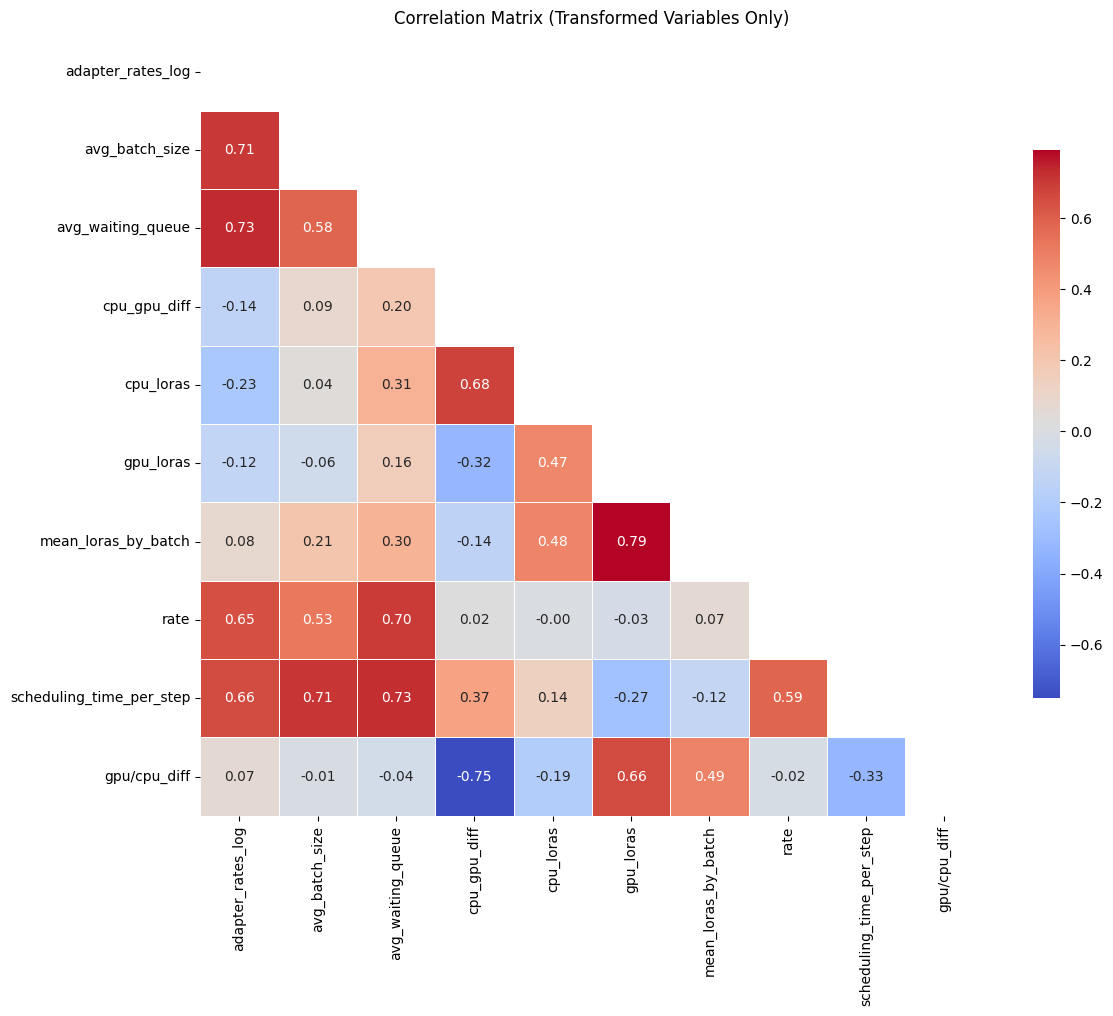


Correlations with transformed scheduling time:
scheduling_time_per_step    1.000000
avg_waiting_queue           0.730327
avg_batch_size              0.714034
adapter_rates_log           0.659892
rate                        0.586488
cpu_gpu_diff                0.371666
gpu/cpu_diff                0.328716
gpu_loras                   0.269491
cpu_loras                   0.138690
mean_loras_by_batch         0.117609
Name: scheduling_time_per_step, dtype: float64


In [17]:
# Create list of original variables that were transformed
transformed_originals = [
    'adapter_rates',
    # 'max_lora_loading_time', 
    # 'max_lora_loads_from_memory_corrected',
    'avg_batch_size_sqrt',
    'scheduling_time_per_step_log' 
]

# Create a new dataframe excluding original variables but keeping their transformations
cols_to_keep = [col for col in df_no_outliers.columns if col not in transformed_originals]

# Create the filtered dataframe
df_model = df_no_outliers[cols_to_keep].copy()

# Confirm the columns we're using
print("Variables for modeling:")
print(df_model.columns.tolist())

# Check correlation matrix with only transformed variables
corr_matrix = df_model.corr()

# Plot updated correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Correlation Matrix (Transformed Variables Only)')
plt.tight_layout()
plt.show()

# Show correlations with target (scheduling_time_per_step)
target_corr = corr_matrix['scheduling_time_per_step'].abs().sort_values(ascending=False)
print("\nCorrelations with transformed scheduling time:")
print(target_corr)

### Correlated variables:
* max_lora_loads_from_memory_corrected_log correlated with max_lora_loading_time_log. We keep max_lora_loads_from_memory_corrected_log.
* rate correlated with avg_waiting_queue. We keep avg_waiting_queue, as it is the most effective in an online setting.
* adapter_rates_log correlated with avg_waiting_queue. Same story we keep avg_waiting_queue.
* mean_loras_by_batch is correlated to gpu_loras which makes sense. gpu_loras is the less correlated one to the target. we would exclude that.

In [18]:
df_model

,adapter_rates_log,avg_batch_size,avg_waiting_queue,cpu_gpu_diff,cpu_loras,gpu_loras,mean_loras_by_batch,rate,scheduling_time_per_step,gpu/cpu_diff
0,-2.079442,5.874552,0.000000,0,8,8,4.065602,1.0,0.000043,1.000000
1,-2.772589,6.093190,0.089606,8,16,8,4.764841,1.0,0.000042,0.500000
2,-3.465736,6.061151,0.187050,24,32,8,5.200201,1.0,0.000042,0.250000
3,-4.158883,6.043011,0.401434,56,64,8,5.618815,1.0,0.000044,0.125000
4,-4.852030,6.197133,0.530466,120,128,8,5.775044,1.0,0.000044,0.062500
...,...,...,...,...,...,...,...,...,...,...
783,-1.609438,151.240741,14286.000000,0,384,384,102.224408,0.2,0.000663,1.000000
784,-1.609438,149.316176,15219.426471,64,448,384,102.643728,0.2,0.000653,0.857143
785,-1.609438,147.635593,15948.838983,128,512,384,103.240859,0.2,0.000748,0.750000
786,-1.609438,129.370370,15166.466667,0,448,448,92.362925,0.2,0.000585,1.000000


In [19]:
df_no_outliers['scheduling_time_per_step']

0      0.000043
1      0.000042
2      0.000042
3      0.000044
4      0.000044
         ...   
783    0.000663
784    0.000653
785    0.000748
786    0.000585
787    0.000626
Name: scheduling_time_per_step, Length: 788, dtype: float64

In [20]:
df_no_outliers['scheduling_time_per_step_diff']=(df_no_outliers['scheduling_time_per_step'] - 0.002).clip(lower=0)

<Figure size 1200x1000 with 0 Axes>

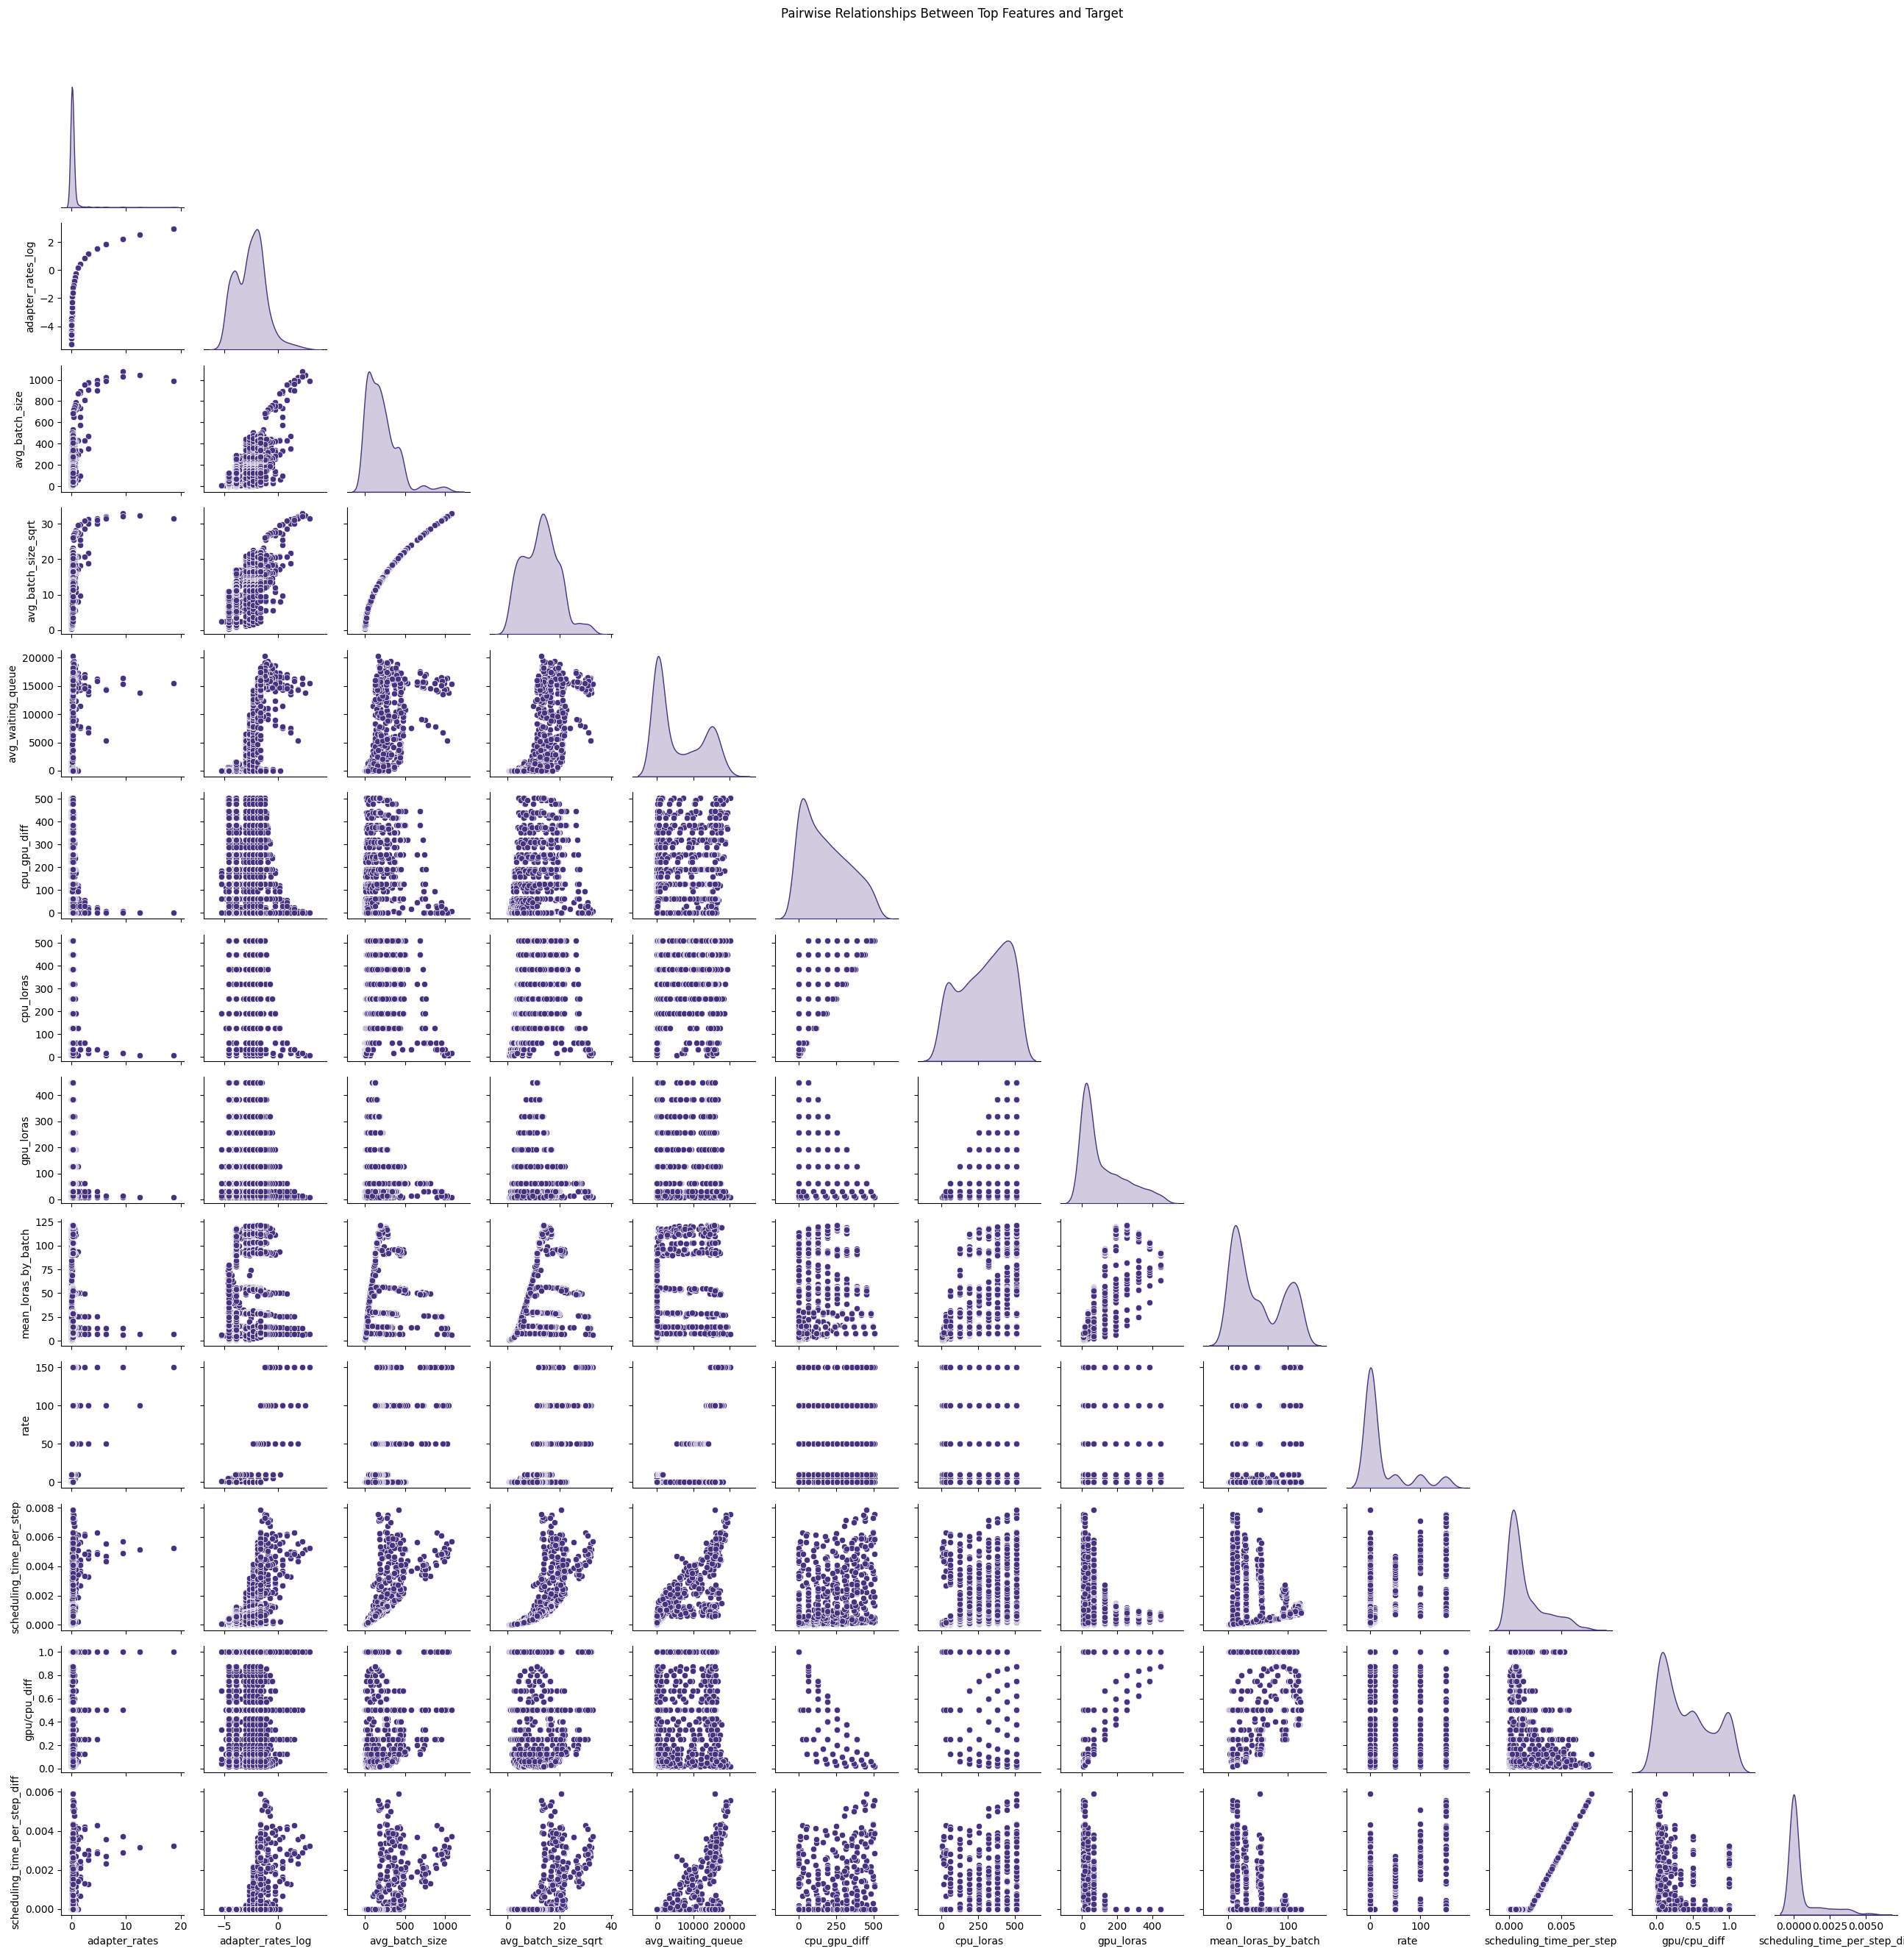

In [21]:
import seaborn as sns

# Create the pairwise plot
plt.figure(figsize=(12, 10))
sns.pairplot(df_no_outliers, height=2, diag_kind='kde',corner=True)
plt.suptitle('Pairwise Relationships Between Top Features and Target', y=1.02)
plt.tight_layout()
plt.show()


* Fer plot de scheduling time per step amb avg waiting queue i colors per cpu_gpu_diff
* Es la variable que explica millor el scheduling time alts. Tenim un doble "nuvol" de punts, entendre la part inferior.
* 


In [22]:
df_no_outliers['gpu/cpu_diff'] =  df_no_outliers['gpu_loras'] /  df_no_outliers['cpu_loras']
df_no_outliers['gpu_cpu_diff'] =  df_no_outliers['gpu_loras'] -  df_no_outliers['cpu_loras']


<Axes: >

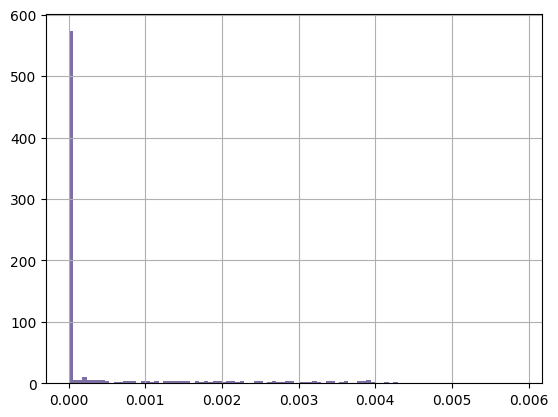

In [23]:
df_no_outliers['scheduling_time_per_step_diff'].hist(bins=100, alpha=0.7)

<Axes: >

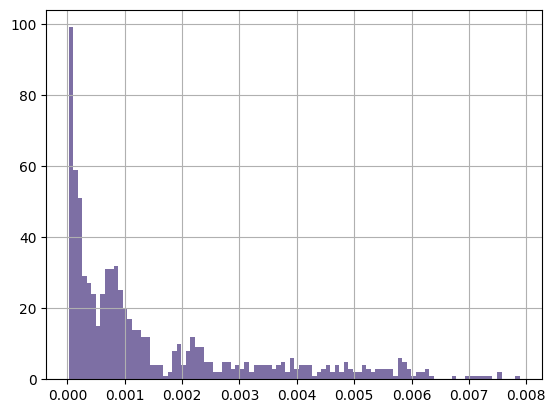

In [24]:
df_no_outliers['scheduling_time_per_step'].hist(bins=100, alpha=0.7)

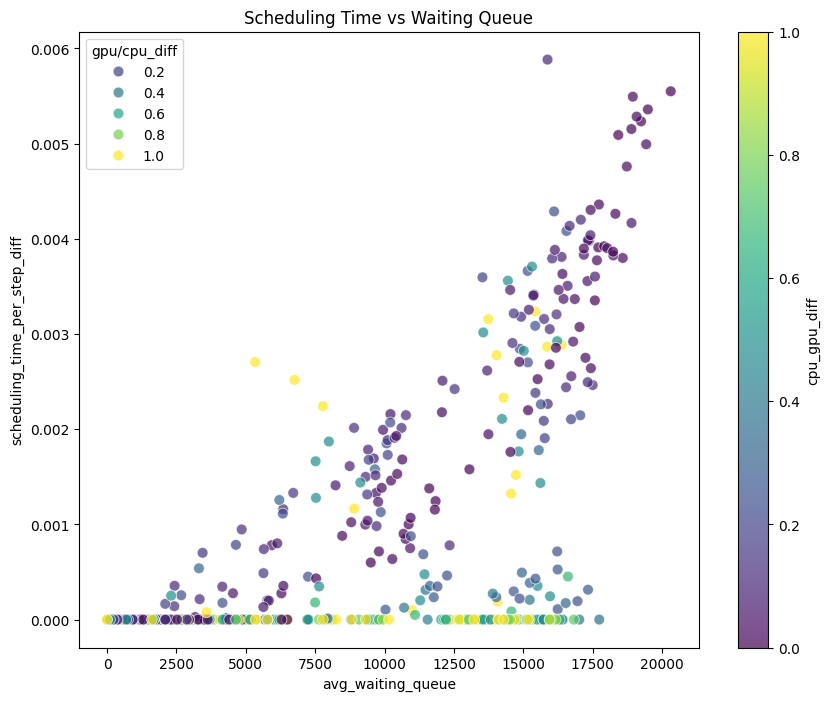

In [25]:

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=df_no_outliers,
    x='avg_waiting_queue',
    y='scheduling_time_per_step_diff',
    hue='gpu/cpu_diff',
    palette='viridis',  # You can change to 'coolwarm', 'RdBu', etc.
    s=60,  # Size of points
    alpha=0.7  # Transparency
)
plt.title('Scheduling Time vs Waiting Queue')
plt.colorbar(scatter.collections[0], label='cpu_gpu_diff')
plt.show()

gpu slots per adapter

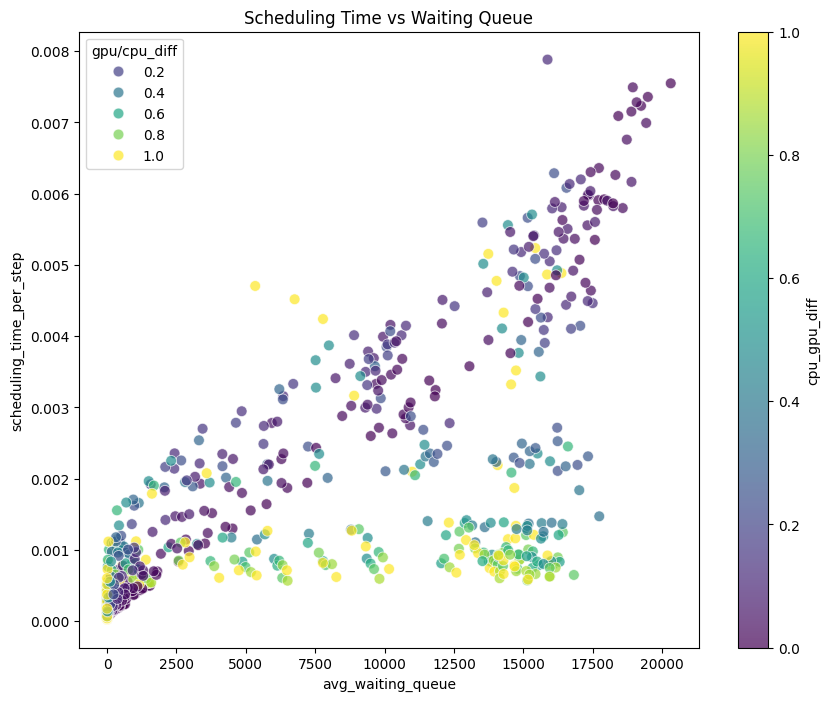

In [26]:

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=df_no_outliers,
    x='avg_waiting_queue',
    y='scheduling_time_per_step',
    hue='gpu/cpu_diff',
    palette='viridis',  # You can change to 'coolwarm', 'RdBu', etc.
    s=60,  # Size of points
    alpha=0.7  # Transparency
)
plt.title('Scheduling Time vs Waiting Queue')
plt.colorbar(scatter.collections[0], label='cpu_gpu_diff')
plt.show()

<Axes: >

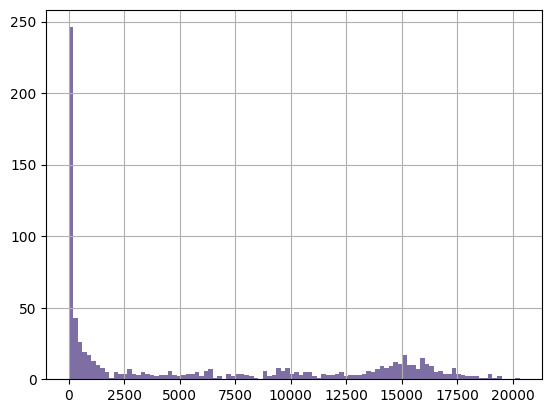

In [27]:
df.avg_waiting_queue.hist(bins=100, alpha=0.7)

In [28]:
df_no_outliers

,adapter_rates,adapter_rates_log,avg_batch_size,avg_batch_size_sqrt,avg_waiting_queue,cpu_gpu_diff,cpu_loras,gpu_loras,mean_loras_by_batch,rate,scheduling_time_per_step,gpu/cpu_diff,scheduling_time_per_step_diff,gpu_cpu_diff
0,0.125000,-2.079442,5.874552,2.423748,0.000000,0,8,8,4.065602,1.0,0.000043,1.000000,0.0,0
1,0.062500,-2.772589,6.093190,2.468439,0.089606,8,16,8,4.764841,1.0,0.000042,0.500000,0.0,-8
2,0.031250,-3.465736,6.061151,2.461941,0.187050,24,32,8,5.200201,1.0,0.000042,0.250000,0.0,-24
3,0.015625,-4.158883,6.043011,2.458254,0.401434,56,64,8,5.618815,1.0,0.000044,0.125000,0.0,-56
4,0.007812,-4.852030,6.197133,2.489404,0.530466,120,128,8,5.775044,1.0,0.000044,0.062500,0.0,-120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,0.200000,-1.609438,151.240741,12.297997,14286.000000,0,384,384,102.224408,0.2,0.000663,1.000000,0.0,0
784,0.200000,-1.609438,149.316176,12.219500,15219.426471,64,448,384,102.643728,0.2,0.000653,0.857143,0.0,-64
785,0.200000,-1.609438,147.635593,12.150539,15948.838983,128,512,384,103.240859,0.2,0.000748,0.750000,0.0,-128
786,0.200000,-1.609438,129.370370,11.374110,15166.466667,0,448,448,92.362925,0.2,0.000585,1.000000,0.0,0


In [29]:
df=df_no_outliers.copy()

In [30]:
df_model

,adapter_rates_log,avg_batch_size,avg_waiting_queue,cpu_gpu_diff,cpu_loras,gpu_loras,mean_loras_by_batch,rate,scheduling_time_per_step,gpu/cpu_diff
0,-2.079442,5.874552,0.000000,0,8,8,4.065602,1.0,0.000043,1.000000
1,-2.772589,6.093190,0.089606,8,16,8,4.764841,1.0,0.000042,0.500000
2,-3.465736,6.061151,0.187050,24,32,8,5.200201,1.0,0.000042,0.250000
3,-4.158883,6.043011,0.401434,56,64,8,5.618815,1.0,0.000044,0.125000
4,-4.852030,6.197133,0.530466,120,128,8,5.775044,1.0,0.000044,0.062500
...,...,...,...,...,...,...,...,...,...,...
783,-1.609438,151.240741,14286.000000,0,384,384,102.224408,0.2,0.000663,1.000000
784,-1.609438,149.316176,15219.426471,64,448,384,102.643728,0.2,0.000653,0.857143
785,-1.609438,147.635593,15948.838983,128,512,384,103.240859,0.2,0.000748,0.750000
786,-1.609438,129.370370,15166.466667,0,448,448,92.362925,0.2,0.000585,1.000000


In [31]:
correlated_cols = [
    'max_lora_loading_time_log',
    'rate', 
    'adapter_rates_log',
    'cpu_gpu_diff',
    # 'mean_loras_by_batch',
    # 'cpu_loras'
    'gpu_loras'
]

# Create a new dataframe excluding original variables but keeping their transformations
cols_to_keep = [col for col in df_model.columns if col not in correlated_cols]

# Create the filtered dataframe
df = df_model[cols_to_keep].copy()

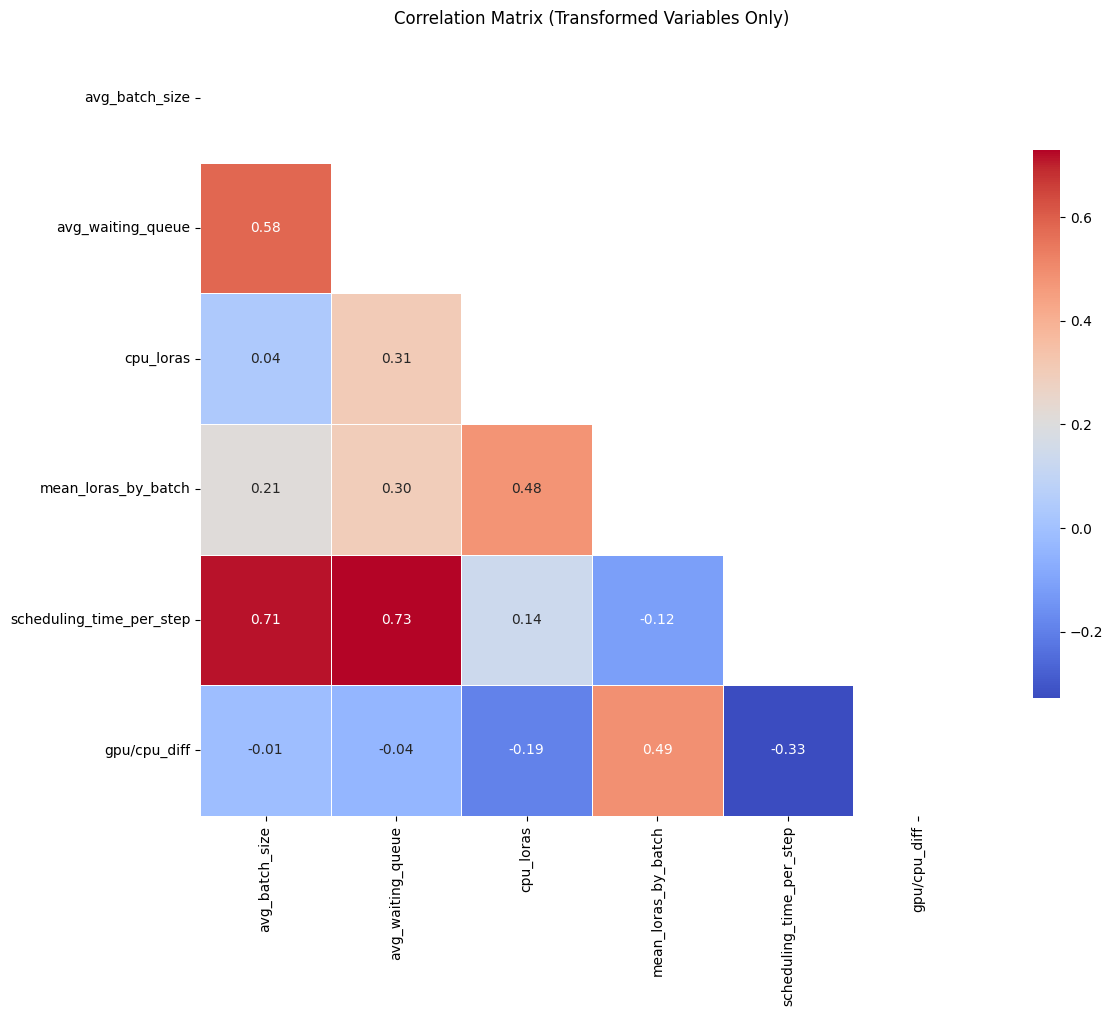


Correlations with transformed scheduling time:
scheduling_time_per_step    1.000000
avg_waiting_queue           0.730327
avg_batch_size              0.714034
gpu/cpu_diff                0.328716
cpu_loras                   0.138690
mean_loras_by_batch         0.117609
Name: scheduling_time_per_step, dtype: float64


In [32]:
# Check correlation matrix with only transformed variables
corr_matrix = df.corr()

# Plot updated correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.title('Correlation Matrix (Transformed Variables Only)')
plt.tight_layout()
plt.show()

# Show correlations with target (step_inv)
target_corr = corr_matrix['scheduling_time_per_step'].abs().sort_values(ascending=False)
print("\nCorrelations with transformed scheduling time:")
print(target_corr)

In [33]:
df

,avg_batch_size,avg_waiting_queue,cpu_loras,mean_loras_by_batch,scheduling_time_per_step,gpu/cpu_diff
0,5.874552,0.000000,8,4.065602,0.000043,1.000000
1,6.093190,0.089606,16,4.764841,0.000042,0.500000
2,6.061151,0.187050,32,5.200201,0.000042,0.250000
3,6.043011,0.401434,64,5.618815,0.000044,0.125000
4,6.197133,0.530466,128,5.775044,0.000044,0.062500
...,...,...,...,...,...,...
783,151.240741,14286.000000,384,102.224408,0.000663,1.000000
784,149.316176,15219.426471,448,102.643728,0.000653,0.857143
785,147.635593,15948.838983,512,103.240859,0.000748,0.750000
786,129.370370,15166.466667,448,92.362925,0.000585,1.000000


In [34]:
# from sklearn.model_selection import train_test_split

# # Split the data into train, validation, and test sets (70/15/15 split)
# X = df.drop('scheduling_time_per_step_diff', axis=1)
# y = df['scheduling_time_per_step_diff']

# # First split: 85% train+val, 15% test
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # Second split: 70% train, 15% validation (from the remaining 85%)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
#                                                   test_size=0.20/0.80, random_state=42)

# print(f"Training set: {X_train.shape[0]} samples")
# print(f"Validation set: {X_val.shape[0]} samples")
# print(f"Test set: {X_test.shape[0]} samples")

In [35]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets (70/15/15 split)
X = df.drop('scheduling_time_per_step', axis=1)
y = df['scheduling_time_per_step']

# First split: 85% train+val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Second split: 70% train, 15% validation (from the remaining 85%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size=0.20/0.80, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 472 samples
Validation set: 158 samples
Test set: 158 samples


## Baseline model

In [36]:
# Step 1: Start with your cleaned data (df_no_outliers) - NO SCALING YET
df_with_interactions = df_no_outliers.copy()

# Step 2: Create interaction terms on the ORIaGINAL scale
# This preserves the true mathematical relationships between variables
df_with_interactions['avg_batch_size_sqrt_x_avg_waiting_queue'] = (
    df_with_interactions['avg_batch_size_sqrt'] * 
    df_with_interactions['avg_waiting_queue']
)

df_with_interactions['avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu_loras'] = (
    df_with_interactions['avg_batch_size_sqrt'] * 
    df_with_interactions['avg_waiting_queue'] * 
    df_with_interactions['gpu_loras']
)

df_with_interactions['cpu_gpu_diff_div_gpu_loras'] = (
    df_with_interactions['cpu_gpu_diff'] / 
    df_with_interactions['gpu_loras']
)

df_with_interactions['avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu/cpu_diff'] = (
    df_with_interactions['avg_batch_size_sqrt_x_avg_waiting_queue'] *
    df_with_interactions['gpu/cpu_diff']
)
df_with_interactions['avg_waiting_queue_x_gpu_loras'] = (
    df_with_interactions['avg_waiting_queue'] * 
    df_with_interactions['gpu_loras']
)
df_with_interactions['avg_waiting_queue_x_gpu/cpu_diff'] = (
    df_with_interactions['avg_waiting_queue'] * 
    df_with_interactions['gpu/cpu_diff']
)
df_with_interactions['avg_waiting_queue_div_gpu/cpu_diff'] = (
    df_with_interactions['avg_waiting_queue'] /
    df_with_interactions['gpu/cpu_diff']
)




In [37]:
# Define your final feature set
cols_to_keep = [
    'avg_batch_size',
    'avg_waiting_queue', 
    'cpu_loras',
    'cpu_gpu_diff',
    'mean_loras_by_batch',
    'gpu/cpu_diff',
    'gpu_loras'
]

interaction_cols = [
    'avg_batch_size_sqrt_x_avg_waiting_queue',
    'avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu_loras',
    'cpu_gpu_diff_div_gpu_loras',
    'avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu/cpu_diff',
    'avg_waiting_queue_x_gpu_loras',
    'avg_waiting_queue_x_gpu/cpu_diff',
    'avg_waiting_queue_div_gpu/cpu_diff'
]

# Combine both sets for comprehensive scaling
cols_to_scale = cols_to_keep + interaction_cols+ ['scheduling_time_per_step']
df_final = df_with_interactions[cols_to_scale].copy()

In [38]:
df_final.describe()

,avg_batch_size,avg_waiting_queue,cpu_loras,cpu_gpu_diff,mean_loras_by_batch,gpu/cpu_diff,gpu_loras,avg_batch_size_sqrt_x_avg_waiting_queue,avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu_loras,cpu_gpu_diff_div_gpu_loras,avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu/cpu_diff,avg_waiting_queue_x_gpu_loras,avg_waiting_queue_x_gpu/cpu_diff,avg_waiting_queue_div_gpu/cpu_diff,scheduling_time_per_step
count,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,7.880000e+02,788.000000,788.000000,7.880000e+02,788.000000,7.880000e+02,788.000000
mean,208.393883,6021.654930,294.873096,180.558376,50.162444,0.424107,114.314721,105908.822843,1.239463e+07,8.186258,42363.952811,8.193884e+05,2461.454665,6.381150e+04,0.001530
std,198.533769,6621.538767,161.136337,150.429163,41.911291,0.346442,124.536375,127920.266259,1.992735e+07,13.530223,73104.261903,1.482554e+06,4001.415074,1.605652e+05,0.001753
min,0.232143,0.000000,8.000000,0.000000,1.024924,0.015625,8.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000022
25%,53.977860,42.541271,192.000000,56.000000,13.060068,0.100000,16.000000,307.779821,6.167013e+03,0.400000,37.304729,1.029819e+03,6.376713,1.306752e+02,0.000238
50%,168.357602,2308.954817,320.000000,144.000000,29.868393,0.333333,64.000000,34776.993582,1.409774e+06,2.000000,4359.750192,9.458276e+04,276.739774,1.049214e+04,0.000820
75%,280.724755,13293.129348,448.000000,304.000000,93.239071,0.714286,192.000000,197880.385408,1.562858e+07,9.000000,61057.555280,8.614950e+05,3307.975558,3.690581e+04,0.002209
max,1081.371212,20309.088235,512.000000,504.000000,121.773905,1.000000,448.000000,525536.508739,8.098856e+07,63.000000,525536.508739,7.149978e+06,16371.311594,1.299782e+06,0.007883


# Scaling


In [39]:
len(df_final)

788

In [40]:
# Extract min and max values
scaling_params = {
    'avg_batch_size': {
        'min': df_final['avg_batch_size'].min(),
        'max': df_final['avg_batch_size'].max()
    },
    'avg_waiting_queue': {
        'min': df_final['avg_waiting_queue'].min(),
        'max': df_final['avg_waiting_queue'].max()
    },
    'avg_waiting_queue_x_gpu/cpu_diff': {
        'min': df_final['avg_waiting_queue_x_gpu/cpu_diff'].min(),
        'max': df_final['avg_waiting_queue_x_gpu/cpu_diff'].max()
    }
}

# Print the values to copy into your predictor
print("SCALING_PARAMS = {")
for feature, params in scaling_params.items():
    print(f"    '{feature}': {{'min': {params['min']:.6f}, 'max': {params['max']:.6f}}},")
print("}")

SCALING_PARAMS = {
    'avg_batch_size': {'min': 0.232143, 'max': 1081.371212},
    'avg_waiting_queue': {'min': 0.000000, 'max': 20309.088235},
    'avg_waiting_queue_x_gpu/cpu_diff': {'min': 0.000000, 'max': 16371.311594},
}


In [41]:
# Separate features and target variable
X = df_final.drop('scheduling_time_per_step', axis=1)
y = df_final['scheduling_time_per_step']

# First split: 80% train+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Second split: 70% train, 15% validation from the remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.20/0.80,  # This gives exactly 15% of total for validation
    random_state=42
)

scaler = MinMaxScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,  # Keep column names!
    index=X_train.index       # Keep index!
)
X_val = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,  # Keep column names!
    index=X_val.index       # Keep index!
)
X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,  # Keep column names!
    index=X_test.index       # Keep index!
)

# Display the shapes of the datasets
print(f"Total dataset shape: {X.shape}")

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df_final)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df_final)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df_final)*100:.1f}%)")

Total dataset shape: (788, 14)
Training set: 472 samples (59.9%)
Validation set: 158 samples (20.1%)
Test set: 158 samples (20.1%)


In [42]:

X_train_baseline = X_train.copy()
X_train_baseline = X_train_baseline.drop(columns=['avg_waiting_queue_x_gpu_loras','avg_batch_size','gpu_loras','cpu_loras','cpu_gpu_diff','mean_loras_by_batch','avg_batch_size_sqrt_x_avg_waiting_queue','avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu_loras','cpu_gpu_diff_div_gpu_loras','avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu/cpu_diff'])
X_with_const = sm.add_constant(X_train_baseline)
initial_model = sm.OLS(y_train, X_with_const).fit()

# Display the summary with p-values
print(initial_model.summary())

                               OLS Regression Results                               
Dep. Variable:     scheduling_time_per_step   R-squared:                       0.736
Model:                                  OLS   Adj. R-squared:                  0.734
Method:                       Least Squares   F-statistic:                     325.4
Date:                      Wed, 12 Nov 2025   Prob (F-statistic):          1.63e-133
Time:                              15:19:16   Log-Likelihood:                 2645.6
No. Observations:                       472   AIC:                            -5281.
Df Residuals:                           467   BIC:                            -5260.
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [43]:
X_train

,avg_batch_size,avg_waiting_queue,cpu_loras,cpu_gpu_diff,mean_loras_by_batch,gpu/cpu_diff,gpu_loras,avg_batch_size_sqrt_x_avg_waiting_queue,avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu_loras,cpu_gpu_diff_div_gpu_loras,avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu/cpu_diff,avg_waiting_queue_x_gpu_loras,avg_waiting_queue_x_gpu/cpu_diff,avg_waiting_queue_div_gpu/cpu_diff
127,0.263194,0.012204,0.619048,0.380952,0.769949,0.390476,0.272727,0.007962,0.006641,0.023810,0.003185,0.004437,0.006056,0.000477
562,0.123242,0.002141,0.238095,0.126984,0.457067,0.492063,0.127273,0.000957,0.000399,0.015873,0.000478,0.000389,0.001328,0.000067
88,0.058389,0.011536,0.047619,0.047619,0.054113,0.238095,0.000000,0.003556,0.000185,0.047619,0.000889,0.000262,0.003578,0.000721
85,0.109369,0.001344,1.000000,0.126984,0.641122,0.873016,1.000000,0.000566,0.001652,0.002268,0.000495,0.001710,0.001459,0.000024
777,0.189549,0.694105,0.619048,0.126984,0.964366,0.796825,0.563636,0.384427,0.641300,0.003968,0.307542,0.504720,0.688846,0.013557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.090933,0.002763,0.111111,0.063492,0.237795,0.492063,0.054545,0.001061,0.000221,0.015873,0.000531,0.000251,0.001714,0.000086
514,0.248779,0.159668,0.746032,0.380952,0.946817,0.492063,0.418182,0.101279,0.126715,0.015873,0.050640,0.087077,0.099037,0.004990
19,0.005242,0.000000,0.365079,0.126984,0.038803,0.661376,0.272727,0.000000,0.000000,0.007937,0.000000,0.000000,0.000000,0.000000
129,0.260809,0.019417,0.873016,0.634921,0.765044,0.274376,0.272727,0.012610,0.010518,0.039683,0.003603,0.007059,0.006882,0.001062


In [44]:
X_train_three_interaction = X_train.copy()
X_train_three_interaction = X_train_three_interaction.drop(columns=['avg_waiting_queue_div_gpu/cpu_diff','gpu/cpu_diff','avg_batch_size_sqrt_x_avg_waiting_queue','avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu_loras','avg_waiting_queue_x_gpu_loras','cpu_gpu_diff_div_gpu_loras','cpu_gpu_diff','cpu_loras','mean_loras_by_batch','gpu_loras','avg_batch_size_sqrt_x_avg_waiting_queue_x_gpu/cpu_diff'])
# X_with_const = sm.add_constant(X_train_three_interaction)
best_model_2 = sm.OLS(y_train, X_train_three_interaction).fit()

# Display the summary with p-values
print(best_model_2.summary())

                                    OLS Regression Results                                   
Dep. Variable:     scheduling_time_per_step   R-squared (uncentered):                   0.932
Model:                                  OLS   Adj. R-squared (uncentered):              0.932
Method:                       Least Squares   F-statistic:                              2142.
Date:                      Wed, 12 Nov 2025   Prob (F-statistic):                   3.11e-273
Time:                              15:19:16   Log-Likelihood:                          2827.9
No. Observations:                       472   AIC:                                     -5650.
Df Residuals:                           469   BIC:                                     -5637.
Df Model:                                 3                                                  
Covariance Type:                  nonrobust                                                  
                                       coef    std err      

In [45]:
best_model_2.params

avg_batch_size                      0.004373
avg_waiting_queue                   0.004615
avg_waiting_queue_x_gpu/cpu_diff   -0.004391
dtype: float64